In [47]:
import os
import random
# import matplotlib.pyplot as plt
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "sans-serif",
#     "font.sans-serif": ["Helvetica"]})
# # for Palatino and other serif fonts use:
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.serif": ["Palatino"],
# })
import pandas as pd
import numpy as np
import yaml
import matplotlib.pyplot as plt
import functools

from scipy import stats
import IPython.display as ipd

In [48]:
df = pd.read_csv('database_mixed_backup.csv')

In [49]:
df = df[df['name'] == 'Dmitrii']
len(df)

273

In [50]:
def extract_model(s):
    return s.split('_')[0]

In [51]:
df['model_A'] = df['denoised_1'].apply(extract_model)
df['model_B'] = df['denoised_2'].apply(extract_model)
df['winner'] = df['preffered_utterance'].apply(extract_model)

In [52]:
baselines_ixs = df['winner'].isin(['RegressionFCNN', 'Noisy'])
df_baselines = df[baselines_ixs].reset_index()
df_others = df[~baselines_ixs].reset_index()

In [53]:
def model_scores(df, confidence_scores=[0, 1, 2]):
    if confidence_scores is None:
        confidence_scores = [1, 1, 1]
        
    confidence_map = {k: score for k, score in zip(['low', 'medium', 'high'], confidence_scores)}
    winner_scores = df['confidence'].apply(lambda k: confidence_map[k])
    all_models = df['winner'].unique()
    
    return {
        model: winner_scores[df['winner'] == model].sum()
        for model in all_models
    }
    
def score_display(df, title=None, **kwargs):
    score_map = model_scores(df, **kwargs)
    all_models = sorted(list(score_map.keys()))
    score_list = [score_map[m] for m in all_models]
    ticks = np.arange(len(all_models))
    
    plt.grid(which='both')
    plt.bar(ticks, score_list)
    plt.xticks(ticks, all_models)
    plt.ylabel('Score')
    if title is not None:
        plt.title(title)
    
CONFS = ['low', 'medium', 'high']
SNRS = [-10, -15, -20, -25]

def list_comb(a, b):
    if type(a) == list:
        if type(b) == list:
            return a + b
        else:
            return a + [b]
    else:
        return [a, b]
        
def dict_merge(a, b, comb_f):
    res = {}
    for k in a.keys() | b.keys():
        if k not in a:
            res[k] = b[k]
        elif k not in b:
            res[k] = a[k]
        else:
            res[k] = comb_f(a[k], b[k])
    return res

def score_display_snrs(df, snrs=SNRS, title=None, **kwargs):
    scores_snr = []
    for snr in snrs:
        df_snr = df[df['snr'] == f'{snr}dB']
        scores_snr.append(model_scores(df_snr, **kwargs))
    
    merge_f = functools.partial(dict_merge, comb_f=list_comb)
    score_series = functools.reduce(merge_f, scores_snr, {})
    
    for m, ys in score_series.items():
        plt.plot(snrs, ys, label=m, marker='o')
        
    if title is not None:
        plt.title(title)
    plt.grid(which='both')
    plt.xticks(snrs)
    plt.xlabel('SNR, dB')
    plt.ylabel('Score')
    plt.legend()

def score_display_both(df, title=None, figsize=(10, 4), **kwargs):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plt.sca(axes[0])
    score_display(df, title='In total', **kwargs)
    plt.sca(axes[1])
    score_display_snrs(df, title='Per SNR', **kwargs)
    
    if title is not None:
        fig.suptitle(title, fontsize=15)
        
    fig.tight_layout()
    plt.show()
    
def count_confs(df):
    return [len(df[df['confidence'] == c]) for c in CONFS]

def conf_scores_pie(df, title=None):
    plt.pie(count_confs(df), labels=CONFS)
    if title is not None:
        plt.title(title)
    
def conf_scores_snrs(df, title=None, snrs=SNRS):
    scores_snr = list(zip(*[count_confs(df[df['snr'] == f'{snr}dB']) for snr in snrs]))
    bottom = np.zeros(len(snrs))
    for i, c in enumerate(CONFS):
        plt.bar(snrs, scores_snr[i], label=c, bottom=bottom)
        bottom += np.array(scores_snr[i])
    plt.ylabel('Count')
    plt.xlabel('SNR, dB')
    if title is not None:
        plt.title(title)
    plt.grid(which='both')
    plt.legend()
    
def conf_scores_both(df, title=None, figsize=(10, 4)):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
    plt.sca(axes[0])
    conf_scores_pie(df, title='In total')
    plt.sca(axes[1])
    conf_scores_snrs(df, title='Per SNR')
    
    if title is not None:
        fig.suptitle(title, fontsize=15)
        
    fig.tight_layout()
    plt.show()

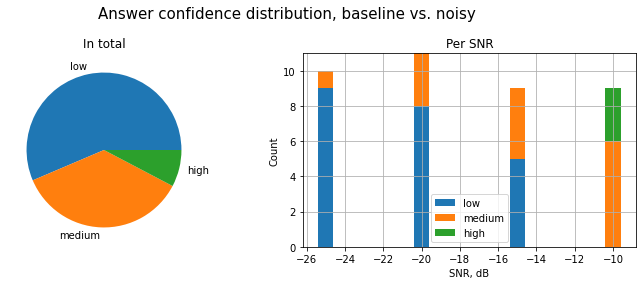

In [54]:
conf_scores_both(df_baselines, 'Answer confidence distribution, baseline vs. noisy')

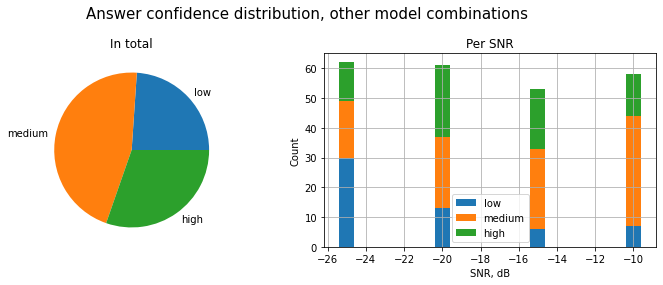

In [55]:
conf_scores_both(df_others, 'Answer confidence distribution, other model combinations')

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

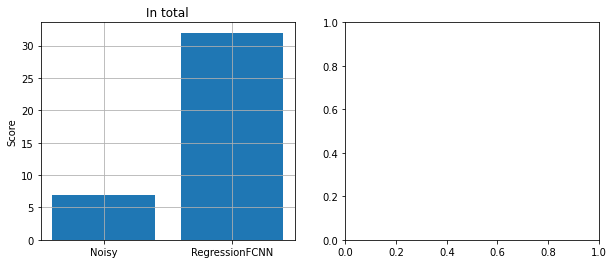

In [56]:
score_display_both(df_baselines, title='Baseline vs. noisy, no confidence scores', confidence_scores=None)

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

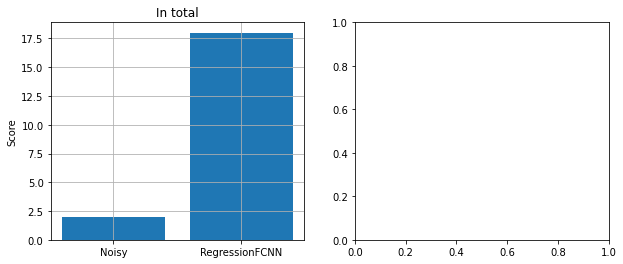

In [57]:
score_display_both(df_baselines, title='Baseline vs. noisy, confidence scores [0, 1, 2]')

ValueError: x and y must have same first dimension, but have shapes (4,) and (3,)

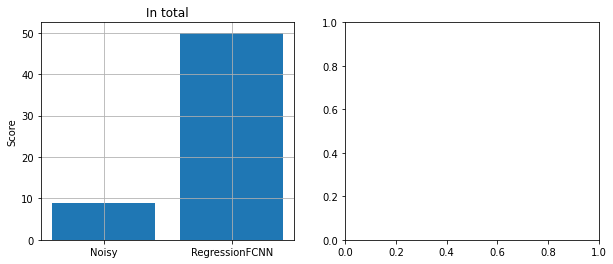

In [58]:
score_display_both(df_baselines, title='Baseline vs. noisy, confidence scores [1, 2, 3]', confidence_scores=[1, 2, 3])

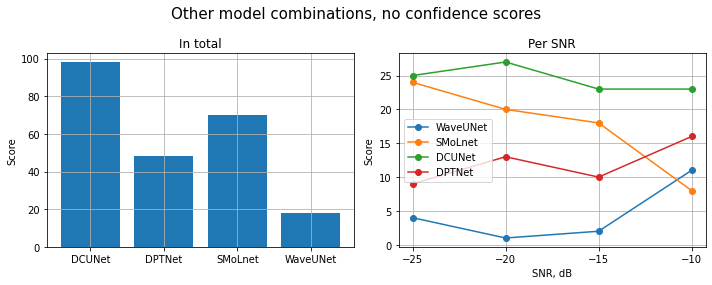

In [59]:
score_display_both(df_others, title='Other model combinations, no confidence scores', confidence_scores=None)

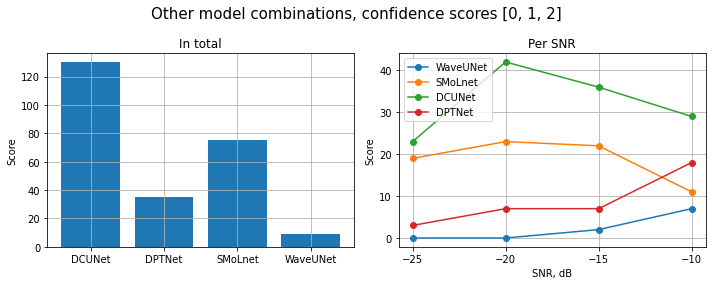

In [60]:
score_display_both(df_others, title='Other model combinations, confidence scores [0, 1, 2]')

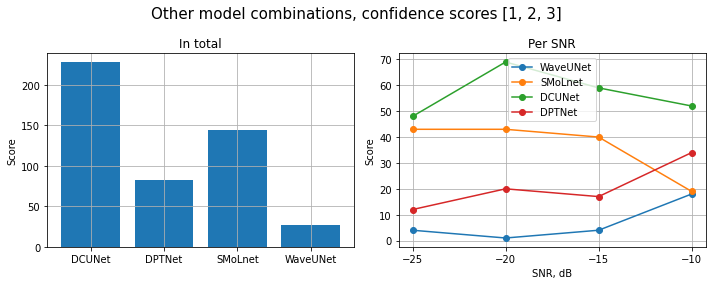

In [61]:
score_display_both(df_others, title='Other model combinations, confidence scores [1, 2, 3]', confidence_scores=[1, 2, 3])

In [41]:
def aggregate_results(dfs, metrics=['pesq', 'estoi', 'si_sdr']):
    return {
        name: df.groupby('snr').agg({
            metric: 'mean' for metric in metrics
        })
        for name, df in dfs.items()
    }

model_csvs = {
    'Noisy': 'input.csv',
    'RegressionFCNN': 'baseline.csv',
    'WaveUNet': 'waveunet_v1.csv',
    'SMoLnet': 'smolnet.csv',
    'DCUNet': 'dcunet_20.csv',
    'DPTNet': 'dptnet.csv',
}

model_obj_scores = aggregate_results({
    m: pd.read_csv(csv) for m, csv in model_csvs.items()
})

for df in model_obj_scores.values():
    df['snr'] = df.index

In [42]:
obj_score_series = {}
metrics = ['pesq', 'estoi', 'si_sdr']
for metric in metrics:
    obj_score_series[metric] = {snr: {} for snr in SNRS}
    obj_score_series[metric]['avg'] = {}
    for model, df in model_obj_scores.items():
        avg = df[df['snr'].isin(SNRS)].mean()[metric]
        obj_score_series[metric]['avg'][model] = avg
        for snr in SNRS:
            obj_score_series[metric][snr][model] = df.loc[snr, metric]

In [43]:
def all_score_series(df, **kwargs):
    series = {}
    series['avg'] = model_scores(df, **kwargs)
    for snr in SNRS:
        df_snr = df[df['snr'] == f'{snr}dB']
        series[snr] = model_scores(df_snr, **kwargs)
    return series

def rank_correlation(a, b):
    model_keys = sorted(list(a.keys() & b.keys()))
    var_a = np.array([a[k] for k in model_keys])
    var_b = np.array([b[k] for k in model_keys])
    return stats.spearmanr(var_a, var_b).correlation

def all_rank_correlations(subj, obj):
    df = pd.DataFrame(columns=metrics)
    for k in subj.keys():
        for m in metrics:
            df.loc[k, m] = rank_correlation(subj[k], obj[m][k])
    return df

In [44]:
conf_score_sets = [
    None,
    [0, 1, 2],
    [1, 2, 3],
]

### Baseline vs. noisy Spearman rank correlations

In [24]:
for confs in conf_score_sets:
    print('Confidence scores: '+str(confs))
    subjs = all_score_series(df_baselines, confidence_scores=confs)
    ipd.display(all_rank_correlations(subjs, obj_score_series))

Confidence scores: None


,pesq,estoi,si_sdr
avg,1.0,-1.0,1.0
-10,1.0,-1.0,1.0
-15,1.0,-1.0,1.0
-20,1.0,-1.0,1.0
-25,1.0,-1.0,1.0


Confidence scores: [0, 1, 2]


/home/flyingleafe/repos/web-drone-project/lib/python3.8/site-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


,pesq,estoi,si_sdr
avg,1.0,-1.0,1.0
-10,1.0,-1.0,1.0
-15,1.0,-1.0,1.0
-20,1.0,-1.0,1.0
-25,NaN,NaN,NaN


Confidence scores: [1, 2, 3]


,pesq,estoi,si_sdr
avg,1.0,-1.0,1.0
-10,1.0,-1.0,1.0
-15,1.0,-1.0,1.0
-20,1.0,-1.0,1.0
-25,1.0,-1.0,1.0


### Other models Spearman rank correlations

In [45]:
for confs in conf_score_sets:
    print('Confidence scores: '+str(confs))
    subjs = all_score_series(df_others, confidence_scores=confs)
    ipd.display(all_rank_correlations(subjs, obj_score_series))

Confidence scores: None


,pesq,estoi,si_sdr
avg,-0.4,0.8,0.8
-10,0.894427,0.894427,0.894427
-15,1.0,0.4,0.8
-20,-0.948683,0.948683,0.316228
-25,-0.4,0.4,0.0


Confidence scores: [0, 1, 2]


,pesq,estoi,si_sdr
avg,-0.4,0.8,0.8
-10,0.8,1.0,1.0
-15,0.4,-0.4,0.2
-20,-0.316228,0.632456,0.948683
-25,-0.632456,0.316228,-0.210819


Confidence scores: [1, 2, 3]


,pesq,estoi,si_sdr
avg,-0.4,0.8,0.8
-10,0.8,1.0,1.0
-15,0.4,-0.4,0.2
-20,-0.4,0.8,0.8
-25,-0.4,0.4,0.0
